# Zillow: What is driving the errors in the Zestimates?

---

Project & Final Report Created By: Rachel Robbins-Mayhill 2022-04-08

---

<img src='Zestimate.png' width="1000" height="1000" align="center"/>

## PROJECT DESCRIPTION

Zillow is the leading real estate and rental marketplace dedicated to empowering consumers with data, inspiration and knowledge around the place they call home, and connecting them with the best local professionals who can help. According to the National Association of Realtors, there are over 119 million homes in the United States, over 5 million of which are sold each year. 80% of these homes have been viewed on Zillow regardless of their market status.

Zillow serves the full lifecycle of owning and living in a home: buying, selling, renting, financing, remodeling and more. It starts with Zillow's living database of more than 110 million U.S. homes - including homes for sale, homes for rent and homes not currently on the market, as well as Zestimate home values, Rent Zestimates and other home-related information.

The Zestimate is a key element driving webtraffic to Zillow, where sellers, buyers, agents, and curiosity-seekers gain knowledge of a home's value. In fact, over the years, Zillow has built a solid reputation around the Zestimate. The Zestimate takes in layers of data regarding a homes features and location and presents buyers and sellars with a value of a home. Zillow publishes Zestimates for 104 million homes, updating them weekly.

Although Zillow has a model to assist in predicting a home's value, they are looking to fine-tune the model and **improve the Zestimate Residual Error**. This project has been requested by the Zillow Data Science Team.

### PROJECT GOAL

The goal of this project is to **find key drivers of logerror** for Single Family Properties and to construct a Machine Learning Regression Model to improve the Zestimate Residual Error (logerror). The model will help Zillow develop more accurate, dependable, and trustworthy Zestimates, thus sustaining and bolstering their loyal customer base. 

Upon completion of the model, the project will make recommendations on what does and doesn't impact logerror and deliver the recommendations in a report to the Data Science team at Zillow, so they can understand the process that developed the conclusion and have the information available to replicate the findings. 

### INITIAL QUESTIONS

Questions
1. Is there a relationship between logerror and lot size in each county?
2. Is there a relationship between logerror and finished square footage of the property in each county?
3. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?
4. Is there a relationship between logerror and longitude and latitude?
5. Controlling for property square footage, what is the relationship between logerror and age of the home?
6. Is there a realtionship between logerror and acres?

---

Imports used for this project can be viewed in the imports.py file located in the Clustering Project Repository.

In [1]:
from imports import *

### I. Acquire the Data

The data for this report was acquired by accessing 'zillow' from the Codeup SQL database. The following query was used to acquire the data:

In [2]:
'''
The query below is used to join 9 tables from the zillow dataset in the Codeup SQL Cloud Database.  
The tables joined are: properties_2017, predictions_2017, airconditioningtype, architecturalstyletype, 
buildingclasstype, heatingorsystemtype, propertylandusetype, storytype, typeconstructiontype. 
The data is filtered to only include the observationswith non-null latitude and longitude and with a 
transaction date occurring in 2017. 
'''

sql = """
SELECT prop.*, 
       pred.logerror, 
       pred.transactiondate, 
       air.airconditioningdesc, 
       arch.architecturalstyledesc, 
       build.buildingclassdesc, 
       heat.heatingorsystemdesc, 
       landuse.propertylandusedesc, 
       story.storydesc, 
       construct.typeconstructiondesc 
FROM   properties_2017 prop  
       INNER JOIN (SELECT parcelid,
       					  logerror,
                          Max(transactiondate) transactiondate 
                   FROM   predictions_2017 
                   GROUP  BY parcelid, logerror) pred
               USING (parcelid) 
       LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
       LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
       LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
       LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
       LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
       LEFT JOIN storytype story USING (storytypeid) 
       LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
WHERE  prop.latitude IS NOT NULL 
       AND prop.longitude IS NOT NULL AND transactiondate <= '2017-12-31' 
"""

In [3]:
# Acquire data from SQL using module found in wrangle.py
df = wrangle.get_zillow()
# Obtain number of rows and columns for orginal dataframe
df.shape

Reading from csv file...


(77381, 67)

### Original DF -> 77,381 rows and 67 columns.

### II. Prepare the Data

This acquired table was then analyzed and cleaned to eliminate data errors, clarify confusion, and code non-numeric data into more useful numeric types. 

#### Tasks for preparing data
Some of the data cleaning and engineering strategies that were employed were:

1. Filtered for only single family residences, including: 
    - #261: Single Family Residential, #262: Rural Residence, #263: Mobile Homes, #264: Townhomes, #265 Cluster Homes, #266: Condominium, #268: Row House,  #273 Bungalow, #275 Manufactured, #276 Patio Home, #279 Inferred Single Family Residence
2. Dropping null values (17 columns, and 15,172 rows in total)
    - dropped columns first wit over 50% missing values, then dropped rows with over 50% missing values. 
3. Dropped Unnecessary / Duplicate columns:
    - censustractandblock','finishedsquarefeet12','buildingqualitytypeid', 'heatingorsystemtypeid', 'propertyzoningdesc', 'heatingorsystemdesc', 'unitcnt' column
4. Clarifying the FIPS/state_county_code definition, identifying the State and Counties the codes belong to.
5. Creating a separate column identifying the county for each property in string format for readability -> county_code_bin
6. Creating dummy columns for county codes.
7. Creating categorical columns to better visualize and compare data for:
    - 7a. square feet -> home_sizes (small, medium, large, extra large)
    - 7b. total rooms -> total_rooms (bedrooms + bathrooms)
    - 7c. bedroom bins -> small, medium, large, extra large
    - 7d. bathroom bins -> small, medium, large, extra large

#### Results of Preparing the Data

In [4]:
df = wrangle.single_family_homes(df)

In [5]:
df= wrangle.remove_columns(df, cols_to_remove = ['censustractandblock','finishedsquarefeet12',
                                     'buildingqualitytypeid', 'heatingorsystemtypeid', 'propertyzoningdesc', 
                                     'heatingorsystemdesc', 'unitcnt'])

In [6]:
df = wrangle.data_prep(df, prop_required_column=.5, prop_required_row=.5)

(62209, 38)


In [7]:
# View of the first 5 rows of the cleaned table
df.shape

(62209, 38)

### Prepared DF -> 62,210 rows and 33 columns.

### Splitting the Data

After preparing the data, it was split into 3 samples; train, validate, and test using:
- Random State: 123
- Splits of: 
    - Test -> 20% of the original dataset. 
    - The remaining 80% of the dataset is divided between valiidate and train
    - Validate (.30*.80) -> 24%  
    - Train (.70*.80) -> 56% 

In [8]:
train, validate, test = wrangle.split_data(df)

Train: 34836 rows, 38 cols
Validate: 14931 rows, 38 cols
Test: 12442 rows, 38 cols


# EXPLORE

Exploration started with looking at the distribution of logerror which appeared to be normally distributed.

### Explore - Univariate

[(-1.0, 1.0), (0.0, 1500.0)]

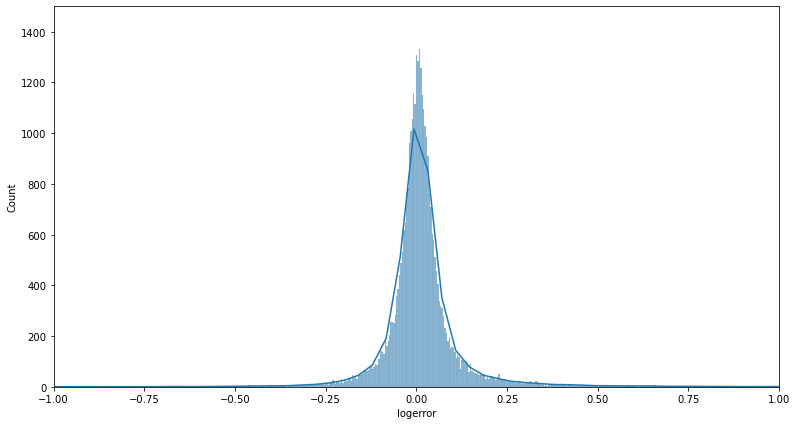

In [9]:
plt.figure(figsize = (13,7))
# Create histogram
ax = sns.histplot(data=train, x="logerror", kde=True)
# set x and y limits to 'zoom in'
ax.set(xlim = (-1, 1), ylim = (0, 1500)) # set the limits to the desired

### Explore - Bivariate

Following the correlation, a pairplot was used to visualize relationships between variables. 

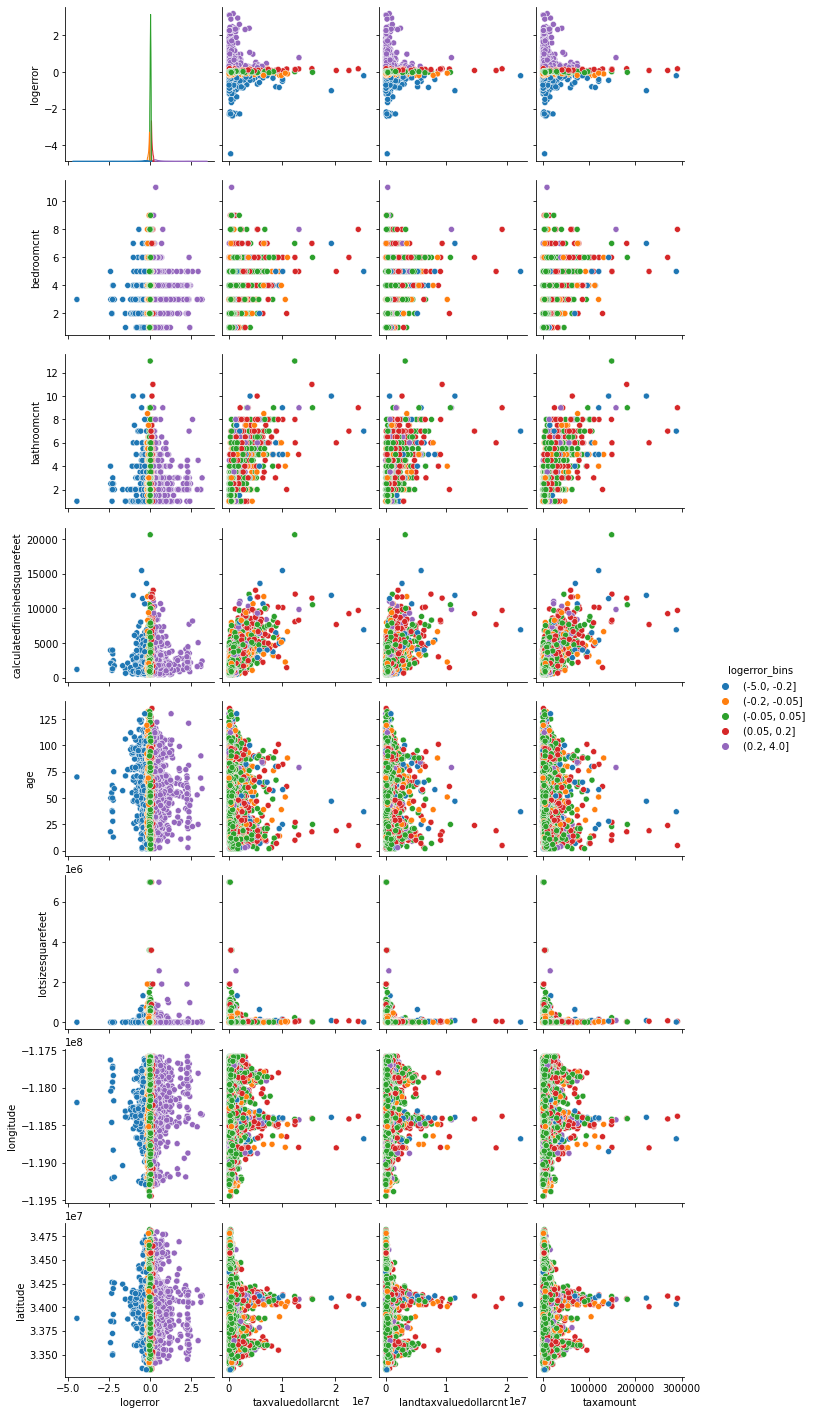

In [10]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount'],
             y_vars = ['logerror', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'age', 'lotsizesquarefeet', 'longitude', 'latitude'])

### Exploration Observations / Takeaways:
- logerror appears to be normally distributed
- logerror higher with odd numbers of bedrooms
- logerror higher when bathrooms have complete number; lower logerror with halfbaths
- logerror higher with calculated squarefeet > 4000
- logerror higher with homes ages between 5 and 80; tend to zillow model tends to overestimate with age
- need to look at lotsize and log error in more detail to see if there is a relationship
- logerror higher with homes that have taxvaluedollarcnt & landtaxvaluedoallarcnt < 500_000, and taxamount < 50_000

## EXPLORE - QUESTIONS

### Questions

- 1. Is there a relationship between logerror and *lot size* in each county?
- 2. Is there a relationship between logerror and finished square footage of the property in each county?
- 3. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?
- 4. Is there a relationship between logerror and longitude and latitude?
- 5. Controlling for property square footage, what is the relationship between logerror and age of the home?

---

### QUESTION 1: LOGERROR & LOT SIZE

#### Is there a relationship between logerror and *lot size* square footage in each county?

#### Visualization 

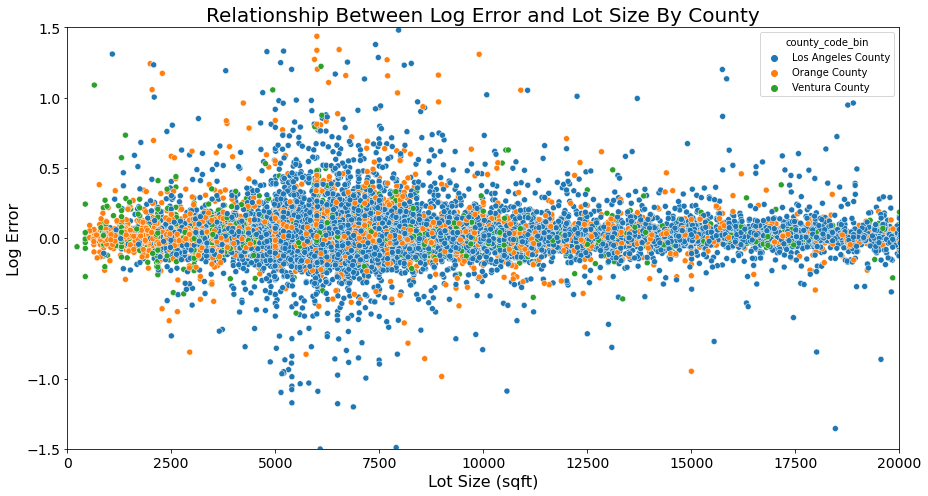

In [11]:
x = train.lotsizesquarefeet
y = train.logerror
# Set size of figure
plt.figure(figsize = (13,7))
# Create scatterplot
ax = sns.scatterplot(data=train, x= x, y= y, hue="county_code_bin")
# set x and y limits to 'zoom in'
ax.set(xlim = (0, 20000), ylim= (-1.5,1.5)) # set the limits to the desired ones
# fit labels and legend
plt.title('Relationship Between Log Error and Lot Size By County', fontsize = 20)
plt.xlabel('Lot Size (sqft)', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Log Error', fontsize = 16)


plt.tight_layout() 
plt.show()

<Figure size 936x504 with 0 Axes>

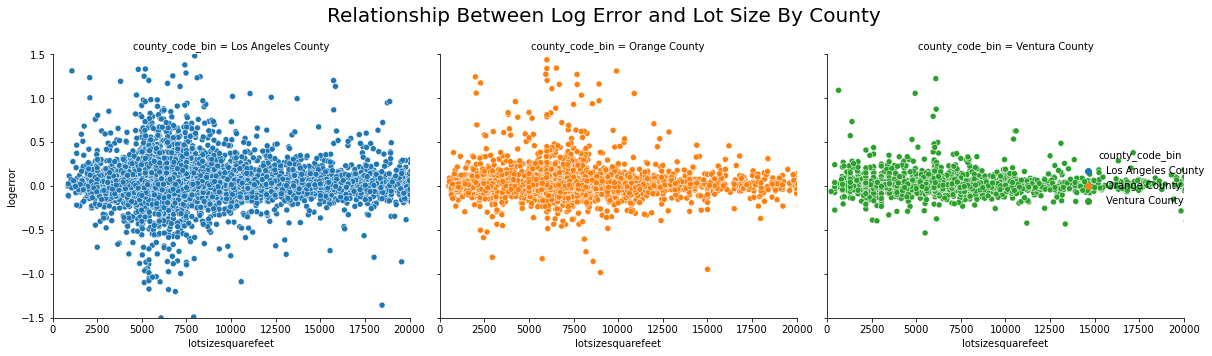

In [12]:
x = train.lotsizesquarefeet
y = train.logerror
# Set size of figure
plt.figure(figsize = (13,7))
# Create scatterplot
ax = sns.relplot(data=train, x= x, y= y, hue="county_code_bin", col="county_code_bin")
# set x and y limits to 'zoom in'
ax.set(xlim = (0, 20000), ylim= (-1.5,1.5)) # set the limits to the desired ones
# fit labels and legend
plt.suptitle('Relationship Between Log Error and Lot Size By County', fontsize = 20)
plt.yticks(fontsize = 14)
plt.ylabel('Log Error', fontsize = 16)


plt.tight_layout() 
plt.show()

#### Observations
- LA County and Orange County have more log error in homes with a lot size between 3000 - 8000 sqft. 
- Is logerror significntly different for homes with lot sizes between 3000-8000 sqft?

#### Hypothesis Testing - Pearson's R
Pearson's R was used because both lotsize and logerror are continuous variables. 

- H$_{0}$: There is no linear relationship between lot size and logerror.
- H$_{a}$: There is a linear realtionship between lot size and log error.

In [13]:
α = 0.05
r, p = stats.pearsonr(x,y)
print('r =', r)
print('p =', p)
if p < α:
    print("We reject the H0.")
else:
    print("We fail to reject the H0.")

r = 0.01885414449791934
p = 0.00043284973126076913
We reject the H0.


Statistical testing with Pearson's R shows the data IS statistically relevant and we reject the null hypothesis that there is no linear relationship between lot size and logerror. 

---

### ANSWER 1: Yes, lot size correlates with logerror (r = 0.018).

======================================================================================================================================

### Question 2: LOGERROR & FINISHED SQFT

#### Is there a relationship between logerror and finished square footage of the property in each county?

#### Visualization 

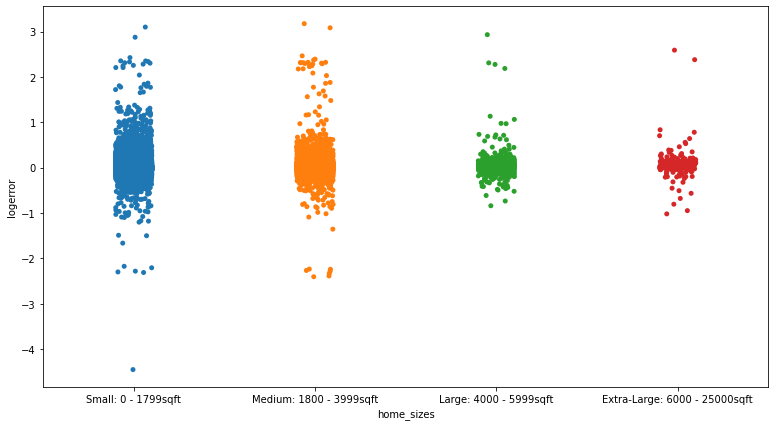

In [14]:
x = train.home_sizes
y = train.logerror
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, data= train.sample(1000))

[(-1.0, 1.0)]

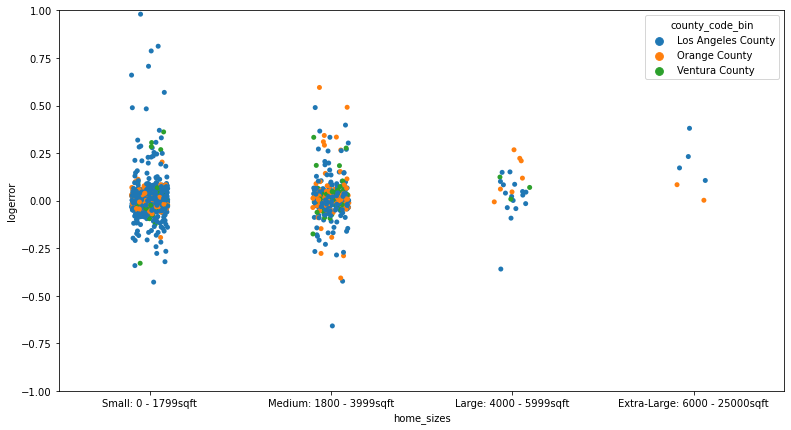

In [15]:
x = 'home_sizes'
y = 'logerror'
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, hue='county_code_bin', data= train.sample(1000))
ax.set(ylim= (-1,1))

#### Hypothesis Testing - 1-Tailed, 1-Sample T-Test - Mean of Subgroup vs. Mean of Overall
T-Test was used to compare the mean of logerror of a sample against the mean logerror overall

- H$_{0}$: Mean of logerror in houses of less than 4000 square feet <= Mean logerror of all home sizes
- H$_{a}$:Mean of logerror in houses of less than 4000 square feet > Mean logerror of all home sizes

In [16]:
alpha = 0.05
logerror_small_med= train[(train.home_sizes.str.startswith('Small'))| (train.home_sizes.str.startswith('Medium'))].logerror
overall_mean = train.logerror.mean()
t, p = stats.ttest_1samp(logerror_small_med, overall_mean)

print(t, p/2, alpha)

if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject the null hypothesis.")
else:
    print("We reject the null hypothesis.")

-1.283039461460382 0.0997435235734488 0.05
We fail to reject the null hypothesis.


Statistical testing with a T-Test shows the data IS NOT statistically relevant and we fail to reject the null hypothesis that mean of logerror in houses of less than 4000 square feet <= mean logerror of all home sizes.

---

### ANSWER 2: 
- No, houses with less than 4000 square feet does  .  No significant difference between the mean of ______ and the mean of ______.

======================================================================================================================================

### Question 3: LOGERROR BY COUNTY

#### Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

#### Visualization 

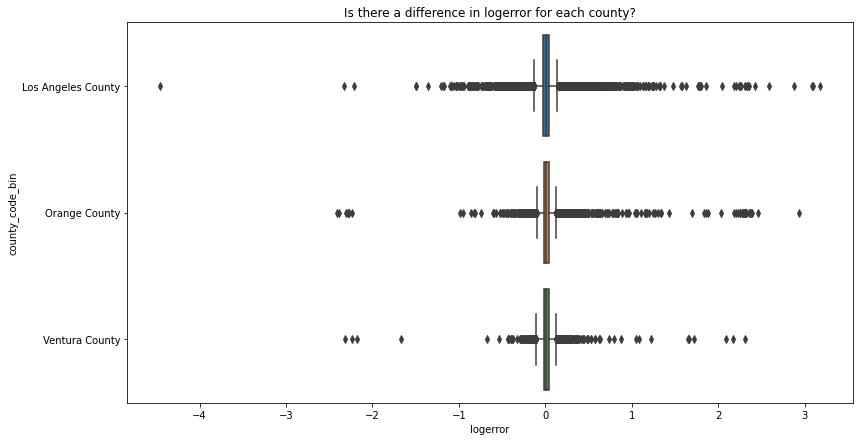

In [22]:
plt.figure(figsize = (13,7))
sns.boxplot(train.logerror, train.county_code_bin)
plt.title("Is there a difference in logerror for each county?")
plt.show()

<Figure size 936x504 with 0 Axes>

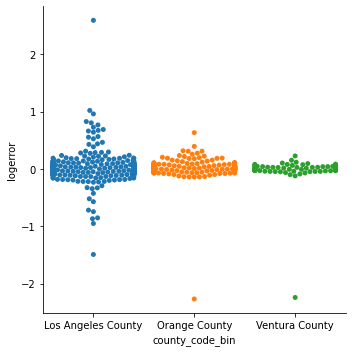

In [25]:
x= 'county_code_bin'
y = 'logerror'
plt.figure(figsize = (13,7))
sns.catplot(x=x, y=y, data= train.sample(1000), kind='swarm')

#### Visualization Takeaways

 - Los Angeles County has a wider variance, followed by Orange County then Ventura. 

#### Hypothesis Testing 

---

### ANSWER 3: 

======================================================================================================================================

### Question 4:  LOGERROR BY LATITUDE & LONGITUDE

#### Is there a relationship between logerror and longitute and latitude?

#### Visualization 

Text(0.5, 1.0, 'Original Data with Cluster Labels')

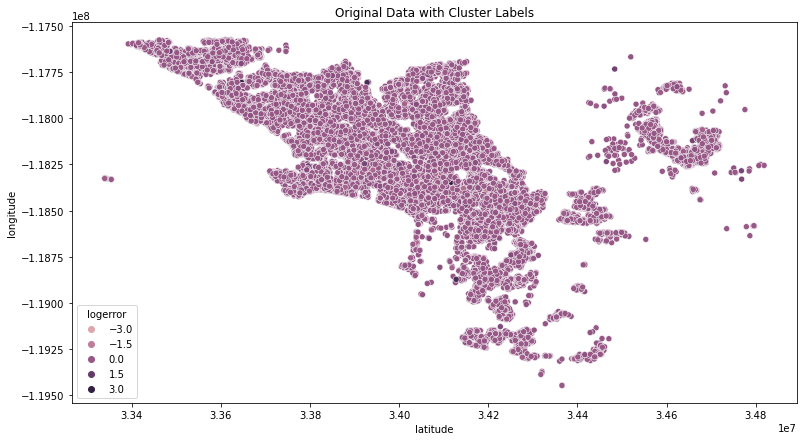

In [24]:
plt.figure(figsize = (13,7))
sns.scatterplot(x='latitude', y='longitude', hue='logerror', data=train)
plt.title('Original Data with Cluster Labels')

#### Visualization Takeaways

#### Hypothesis Testing 

### Question 5: 

#### Visualization 

---

======================================================================================================================================

### Question 5: 

#### Controlling for property square footage, what is the relationship between logerror and age of the home?

#### Visualization 

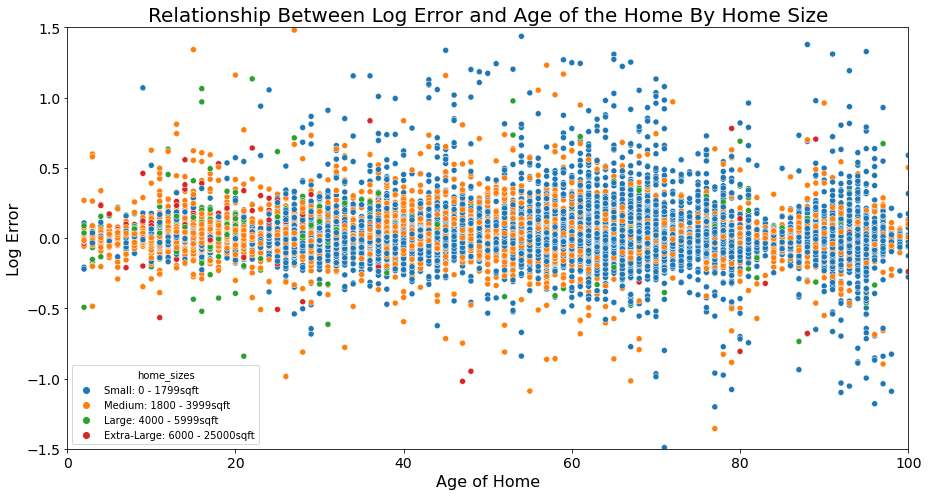

In [26]:
x = train.age
y = train.logerror

# Set size of figure
plt.figure(figsize = (13,7))
# Create scatterplot
ax = sns.scatterplot(data=train, x= x, y= y, hue="home_sizes")
# set x and y limits to 'zoom in'
ax.set(xlim = (0, 100), ylim= (-1.5,1.5)) # set the limits to the desired ones
# fit labels and legend
plt.title('Relationship Between Log Error and Age of the Home By Home Size', fontsize = 20)
plt.xlabel('Age of Home', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Log Error', fontsize = 16)


plt.tight_layout() 
plt.show()

<Figure size 936x504 with 0 Axes>

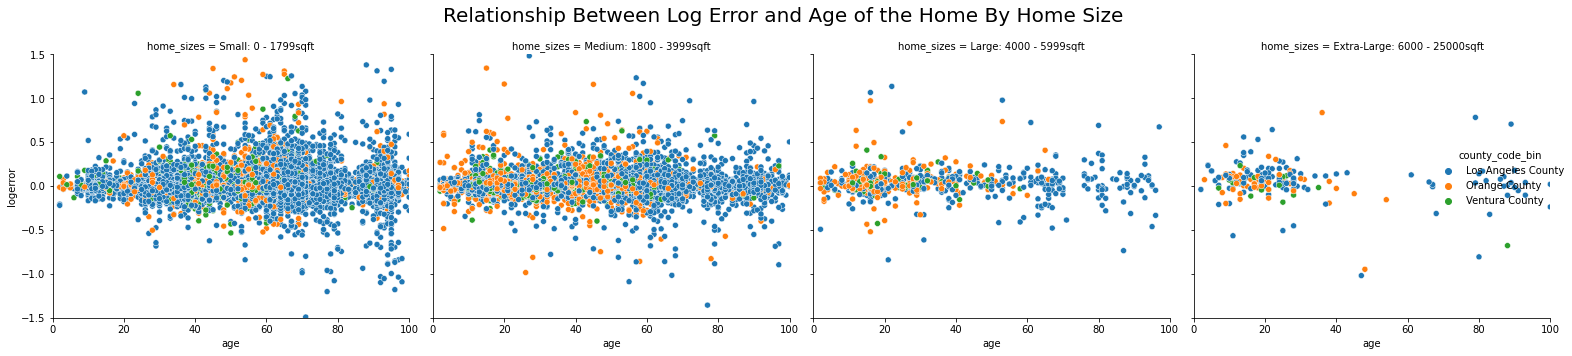

In [27]:
x = train.age
y = train.logerror
# Set size of figure
plt.figure(figsize = (13,7))
# Create scatterplot
ax = sns.relplot(data=train, x= x, y= y, hue="county_code_bin", col="home_sizes")
# set x and y limits to 'zoom in'
ax.set(xlim = (0, 100), ylim= (-1.5,1.5)) # set the limits to the desired ones
# fit labels and legend
plt.suptitle('Relationship Between Log Error and Age of the Home By Home Size', fontsize = 20)
plt.yticks(fontsize = 14)
plt.ylabel('Log Error', fontsize = 16)


plt.tight_layout() 
plt.show()

#### Visualization Takeaways
- Log error for small and medium sized homes (400 - 3900 sqft) is significantly more than large and extra large homes, particulalry when a home is over 40 years old. 

#### Hypothesis Testing 

======================================================================================================================================

### Question 6: 

#### Is there a realtionship between logerror and acres?

#### Visualization 

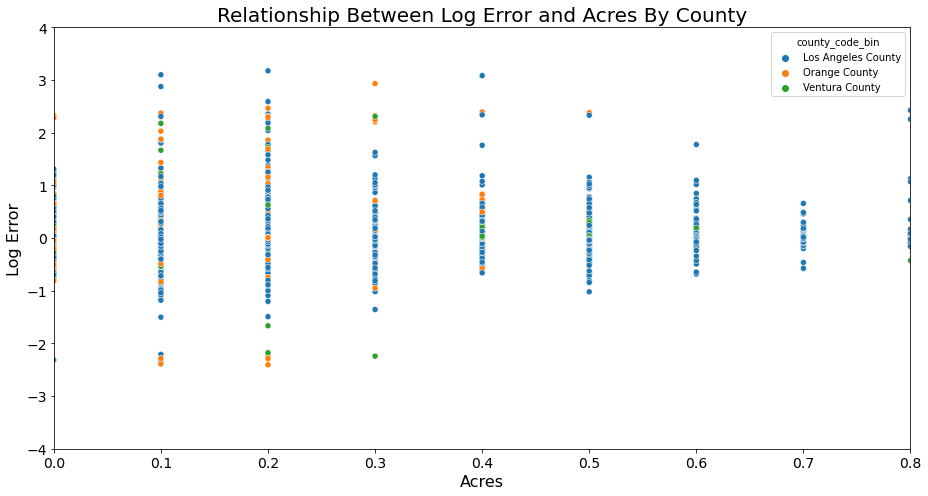

In [28]:
x = train.acres_bin
y = train.logerror
# Set size of figure
plt.figure(figsize = (13,7))
# Create scatterplot
ax = sns.scatterplot(data=train, x= x, y= y, hue="county_code_bin")
# set x and y limits to 'zoom in'
ax.set(xlim = (0, .8), ylim= (-4,4)) # set the limits to the desired ones
# fit labels and legend
plt.title('Relationship Between Log Error and Acres By County', fontsize = 20)
plt.xlabel('Acres', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Log Error', fontsize = 16)


plt.tight_layout() 
plt.show()

<Figure size 936x504 with 0 Axes>

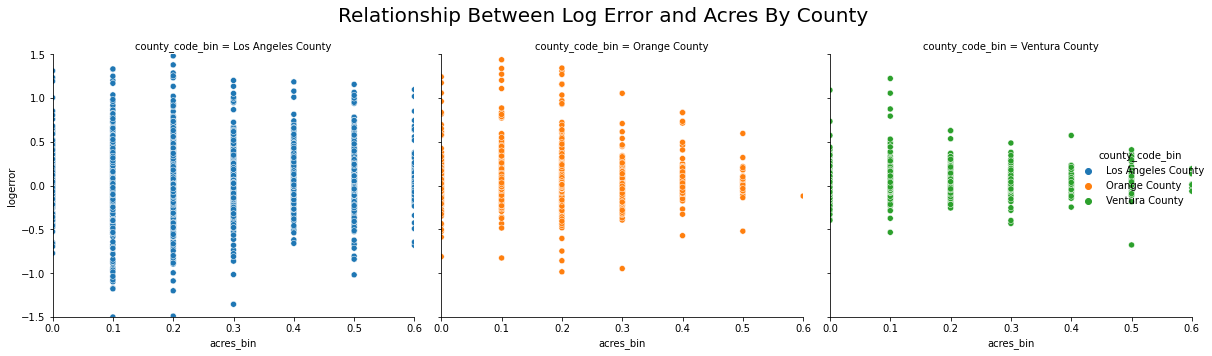

In [29]:
x = train.acres_bin
y = train.logerror
# Set size of figure
plt.figure(figsize = (13,7))
# Create scatterplot
ax = sns.relplot(data=train, x= x, y= y, hue="county_code_bin", col="county_code_bin")
# set x and y limits to 'zoom in'
ax.set(xlim = (0, 0.6), ylim= (-1.5,1.5)) # set the limits to the desired ones
# fit labels and legend
plt.suptitle('Relationship Between Log Error and Acres By County', fontsize = 20)
plt.yticks(fontsize = 14)
plt.ylabel('Log Error', fontsize = 16)


plt.tight_layout() 
plt.show()

#### Visualization Takeaways

#### Hypothesis Testing 

---

======================================================================================================================================

## Exploration Summary:

======================================================================================================================================

#### Set X and y

In [30]:
target = "logerror"
columns = ['age', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'total_rooms', 'bathroomcnt', 'bedroomcnt', 'latitude', 'longitude']
# split train into X (dataframe, drop target) & y (series, keep target only)
X_train = train[columns]
y_train = train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate = validate[columns]
y_validate = validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test = test[columns]
y_test = test[target]

In [31]:
# Observe size of train, validate, teest splits
X_train.shape, X_validate.shape, X_test.shape

((34836, 8), (14931, 8), (12442, 8))

---

## Clustering

After exploring through visualizations and statistical testing, a few features stood out as possiblities for clustering.  



- A. AGE & SQFT (age_size_cluster)
- B. AGE & LOT SIZE (age_lot_cluster)
- C. SQFT & LOT SIZE (size_cluster)
- 

### A. AGE & SQFT (age_size_cluster)

### Scale the Data

In [32]:
#Exploring one version of clustering - scaling only applied to train for now until we determine it is useful
cluster_vars = ['age', 'calculatedfinishedsquarefeet']
cluster_name = 'age_size_cluster'

scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train[cluster_vars])

X_train_scaled = scaler.transform(X_train[cluster_vars])

In [33]:
# Like our other scikit-learn models, we'll create the instance of the k-means class, then fit it to our data. Once we've done that, we can use the object to make predictions.
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_scaled)

kmeans.predict(X_train_scaled)

array([0, 0, 1, ..., 2, 0, 2], dtype=int32)

In [34]:
#The numbers output here are the groups that our K-means algorithm predicted each row to be in. Let's go ahead and store the predicted cluster back into our original dataframe.
train['age_size_cluster'] = kmeans.predict(X_train_scaled)

Text(0.5, 1.0, 'Original Data with Cluster Labels')

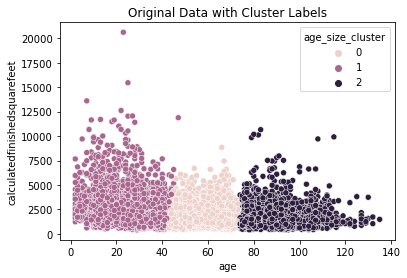

In [35]:
sns.scatterplot(x='age', y='calculatedfinishedsquarefeet', hue='age_size_cluster', data=train)
plt.title('Original Data with Cluster Labels')

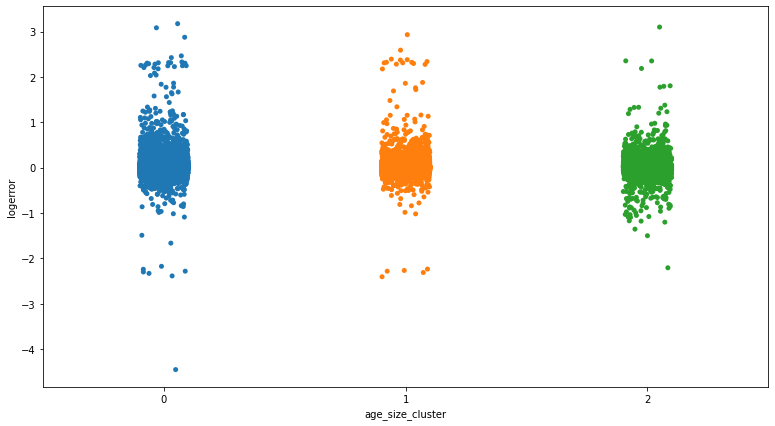

In [36]:
x = train.age_size_cluster
y = train.logerror
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, data= train.sample(1000))

In [37]:
train.groupby('age_size_cluster')['age', 'calculatedfinishedsquarefeet', 'logerror'].mean()

,age,calculatedfinishedsquarefeet,logerror
age_size_cluster,,,
0,57.91,"1,597.60",0.02
1,27.39,"2,136.82",0.02
2,88.82,"1,549.12",0.01


In [38]:
### A. Observation:
- There is no significant difference, which tells us these clusters are not helpful in predicting logerror.
- The clusters appear to be older homes with smaller square footage. 
    - Age 89, 1500 sqft
    - Age 28, 2100 sqft
    - Age 58, 1600 sqft

SyntaxError: invalid syntax (3451670725.py, line 2)

---

### B. AGE & LOT SIZE (age_lot_cluster)

### Scale the Data

In [ ]:
#Exploring one version of clustering - scaling only applied to train for now until we determine it is useful
cluster_vars = ['age', 'lotsizesquarefeet']
cluster_name = 'age_lot_cluster'

scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train[cluster_vars])

X_train_scaled = scaler.transform(X_train[cluster_vars])

In [ ]:
# Like our other scikit-learn models, we'll create the instance of the k-means class, then fit it to our data. Once we've done that, we can use the object to make predictions.
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_scaled)

kmeans.predict(X_train_scaled)

In [ ]:
#The numbers output here are the groups that our K-means algorithm predicted each row to be in. Let's go ahead and store the predicted cluster back into our original dataframe.
train['age_lot_cluster'] = kmeans.predict(X_train_scaled)

In [ ]:
x = train.age_lot_cluster
y = train.logerror
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, data= train.sample(1000))

In [ ]:
sns.scatterplot(x='age', y='lotsizesquarefeet', hue='age_size_cluster', data=train)
plt.title('Original Data with Cluster Labels')

In [ ]:
train.groupby('age_lot_cluster')['age', 'lotsizesquarefeet', 'logerror'].mean()

### B. Observation:
- There is no significant difference, which tells us these clusters are not helpful in predicting logerror.
- The clusters appear to be older homes with large lot size. 
    - Age 29, 49K sqft lot
    - Age 58, 20K sqft lot
    - Age 88, 9k sqft lot

---

### C. SQFT & LOT SIZE (size_cluster)

### Scale the Data

In [39]:
#Exploring one version of clustering - scaling only applied to train for now until we determine it is useful
cluster_vars = ['calculatedfinishedsquarefeet', 'lotsizesquarefeet']
cluster_name = 'size_cluster'

scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train[cluster_vars])

X_train_scaled = scaler.transform(X_train[cluster_vars])

In [40]:
# Like our other scikit-learn models, we'll create the instance of the k-means class, then fit it to our data. Once we've done that, we can use the object to make predictions.
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_scaled)

kmeans.predict(X_train_scaled)

array([0, 0, 2, ..., 0, 0, 0], dtype=int32)

In [41]:
#The numbers output here are the groups that our K-means algorithm predicted each row to be in. Let's go ahead and store the predicted cluster back into our original dataframe.
train['size_cluster'] = kmeans.predict(X_train_scaled)

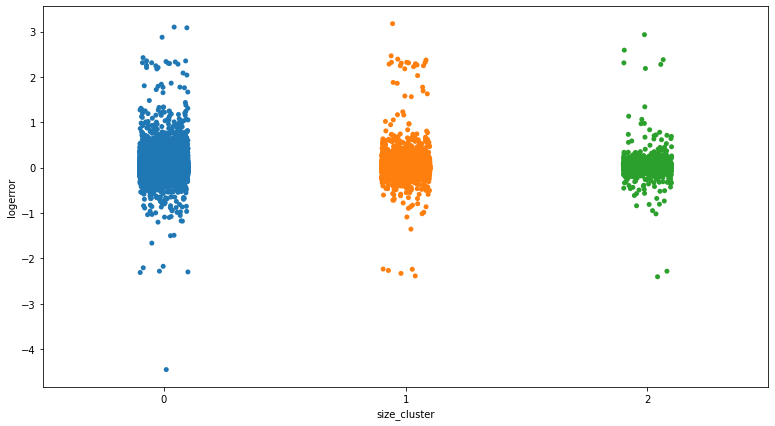

In [42]:
x = train.size_cluster
y = train.logerror
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, data= train.sample(1000))

Text(0.5, 1.0, 'Original Data with Cluster Labels')

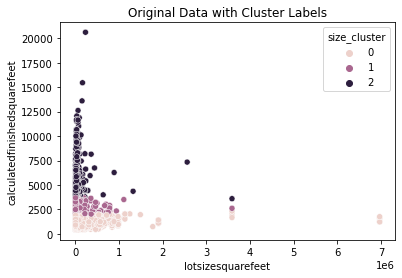

In [43]:
sns.scatterplot(x='lotsizesquarefeet', y='calculatedfinishedsquarefeet', hue='size_cluster', data=train)
plt.title('Original Data with Cluster Labels')

In [44]:
train.groupby('size_cluster')['lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'logerror'].mean()

,lotsizesquarefeet,calculatedfinishedsquarefeet,logerror
size_cluster,,,
0,"35,678.24","1,318.09",0.02
1,"16,309.33","2,538.29",0.02
2,"31,651.19","4,907.22",0.04


In [45]:
### C. Observation:
- There is no significant difference, which tells us these clusters are not helpful in predicting logerror.

- The clusters appear to be small to medium sized square feet and large lot size. 
    - Lot 35K, Home 1,300 sq ft. 
    - Lot 24K, Home 4,500 sq ft. 
    - Lot 18K, Home 2,400 sq ft. 

SyntaxError: invalid syntax (1897488839.py, line 2)

---

### D. Latititude & Longitude (location_cluster)

### Scale the Data

In [46]:
#Exploring one version of clustering - scaling only applied to train for now until we determine it is useful
cluster_vars = ['latitude', 'longitude']
cluster_name = 'location_cluster'

scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train[cluster_vars])

X_train_scaled = scaler.transform(X_train[cluster_vars])

In [47]:
# Like our other scikit-learn models, we'll create the instance of the k-means class, then fit it to our data. Once we've done that, we can use the object to make predictions.
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_scaled)

kmeans.predict(X_train_scaled)

array([2, 0, 2, ..., 0, 1, 0], dtype=int32)

In [48]:
#The numbers output here are the groups that our K-means algorithm predicted each row to be in. Let's go ahead and store the predicted cluster back into our original dataframe.
train['location_cluster'] = kmeans.predict(X_train_scaled)

Text(0.5, 1.0, 'Original Data with Cluster Labels')

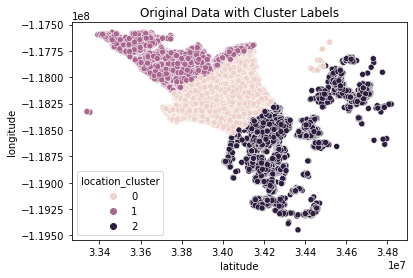

In [49]:
sns.scatterplot(x='latitude', y='longitude', hue='location_cluster', data=train)
plt.title('Original Data with Cluster Labels')

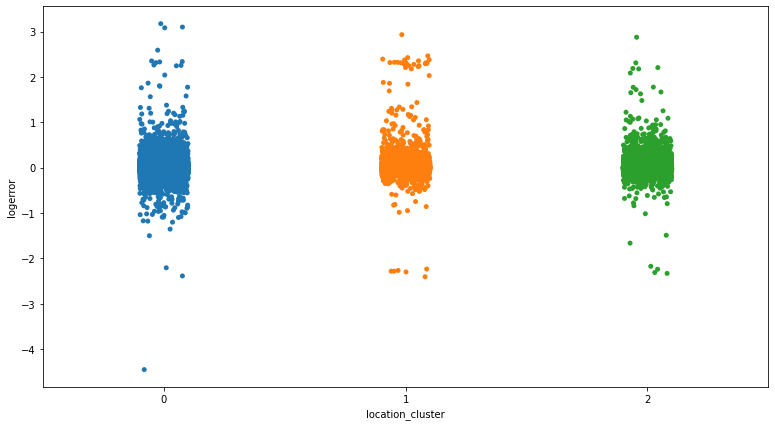

In [50]:
x = train.location_cluster
y = train.logerror
plt.figure(figsize = (13,7))
ax = sns.stripplot(x=x, y=y, data= train.sample(1000))

In [51]:
train.groupby('location_cluster')['latitude', 'longitude', 'logerror'].mean()

,latitude,longitude,logerror
location_cluster,,,
0,"33,993,161.70","-118,208,884.77",0.01
1,"33,745,740.83","-117,831,951.65",0.03
2,"34,316,850.07","-118,563,889.11",0.02


### D. Observation:
- There is no significant difference, which tells us these clusters are not helpful in predicting logerror.

- The clusters appear to be small to medium sized square feet and large lot size. 
    - Lot 35K, Home 1,300 sq ft. 
    - Lot 24K, Home 4,500 sq ft. 
    - Lot 18K, Home 2,400 sq ft. 

======================================================================================================================================

## DATA MODELING

After setting the X and y, and conducting feature selection/engineering, the baseline was set and 4 models were produced:
- Set X and y with target as logerror (above in explore)
- Set Baseline
- Create 4 models:
    - LinearRegression (OLS)
    - LASSO + LARS on X-Train
    - LASSO + LARS on age and calculated square feet
    - Polynomial Regression
- Evaluate the models

### Baseline

In [59]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

# compute logerror_pred_median, setting the baseline on the median logerror.
y_train['baseline'] = y_train['logerror'].median()
y_validate['baseline'] = y_train.logerror.median()

### LASSO + LARS

In [60]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series
lars.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lasso_lars'] = lars.predict(X_train)
y_validate['logerror_pred_lasso_lars']= lars.predict(X_validate)

In [61]:
#'lotsizesquarefeet', 'total_rooms', 'bathroomcnt', 'bedroomcnt', 'latitude', 'longitude']

# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series
lars.fit(X_train[['age', 'calculatedfinishedsquarefeet']], y_train.logerror)

# predict train
y_train['logerror_pred_lasso_lars_age_sqft'] = lars.predict(X_train[['age', 'calculatedfinishedsquarefeet']])
y_validate['logerror_pred_lasso_lars_age_sqft']= lars.predict(X_validate[['age', 'calculatedfinishedsquarefeet']])

### Polynomial Regression

In [62]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [63]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)
#y_test = pd.DataFrame(y_test)

### Outcome of Modeling

In [64]:
pd.options.display.float_format = '{:.6f}'.format
# Create a dataframe with model results for train and validate.
model_results = pd.concat([
    y_train.apply(lambda col: mean_squared_error(y_train.logerror, col)**(1/2)).rename('train'),
    y_validate.apply(lambda col: mean_squared_error(y_validate.logerror, col)**(1/2)).rename('validate')
], axis=1)
model_results.sort_values('validate')

,train,validate
logerror,0.000000,0.000000
logerror_pred_lm2,0.160991,0.169750
logerror_pred_lasso_lars,0.161401,0.169914
logerror_pred_lasso_lars_age_sqft,0.161401,0.169914
baseline,0.161749,0.170213


---

### Best Performing Model Applied to Test Data (Unseen Data)

The model that performed best was the Polynomial Regression Model with a degree of 2. It produced a logerror that would be off by 0.160 on train, performing 0.47% better than the baseline of 0.167. It produced a logerror that would be off by 0.169 on validate, performing -4.94% worse than baseline. Due to it's perferred performance out of the alternative models, it was applied to the test set. 

In [68]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our test data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_test_degree2, y_test.logerror)

# predict train
y_test['logerror_pred_lm2'] = lm2.predict(X_test_degree2)


---

### Results of Model on Test Data

In [69]:
# Create a dataframe with model results for train, validate, and test.
model_results = pd.concat([
    y_train.apply(lambda col: mean_squared_error(y_train.logerror, col)**(1/2)).rename('train'),
    y_validate.apply(lambda col: mean_squared_error(y_validate.logerror, col)**(1/2)).rename('validate'),
    y_test.apply(lambda col: mean_squared_error(y_test.logerror, col)**(1/2)).rename('test')
], axis=1)
model_results

,train,validate,test
logerror,0.000000,0.000000,0.000000
baseline,0.161749,0.170213,NaN
logerror_pred_lasso_lars,0.161401,0.169914,NaN
logerror_pred_lasso_lars_age_sqft,0.161401,0.169914,NaN
logerror_pred_lm2,0.160991,0.169750,0.170139
assessed_value_pred_lm2,NaN,NaN,0.170139


The Polynomial Regression Model with a degree of 2, produced a logerror that would be off by 0.170 on the unseen test data, or 6% worse than baseline, which is how it would be expected to perform on future unseen data.

---

## CONCLUSION

### Summary
The goal of this report was to identify drivers of logerror for Single Family Residences and to use the drivers identified to construct a Machine Learning Model to predict logerror. The best performing model did not predict logerror better than the baseline, instead predicting logerror 6% worse than baseline. This indicates more work needs to be done to identify drivers of logerror.  

### Recommendations for the Data Science Team

- CONTINUE TO COLLECT MORE DATA: The dataset had many missing values resulting in the dropping of  17 columns, and 15,172 rows in total. It is recommended that steps be taken to collect or impute data for the missing values to aid in providing more robust data for analysis. 

- USE THE IDENTIFIED TAKEAWAYS REGARDING LOGERROR: The data shows homes with larger lot sizes, smaller homes, and older homes have more logerror. It is recommended more exploration be done with these features to identify more narrow pinpointed clusters of features with higher logerror. 

- BUILD UPON MODEL PERFORMANCE: Although multiple models were created, none performed significantly better than baseline. Continue to identify more pinpointed features and build models on those features to identify an improved model. 

- CONTINUE to PINPOINT HOME FEATURES DRIVING LOGERROR: This report focused on lot size, home size, age of home, and longitutde, latitude, and county as potential drivers of logerror. It is recommended further analysis and modeling be done with additional features in order to create models with improved performance. 

### Next Steps

If given more time, further exploration would be beneficial in the following areas, in order to produce a more beneficial prediction model:
- Invesitgate missing values, identifying areas to impute. 

- Eliminating outliers to produce more accurate modeling/predictions.

- Identifying more features of properties that may be drivers of property values, such as pools or outbuildings to obtain a more precise view of factors impacting logerror. 

- Compare specific features to see which have more impact on property value, such as adding another room versus adding overall square footage to identify the dollar-for-dollar weight of specific features. 

- Analyzing feature impact within each county and comparing the impact across counties to determine which features have greater impact on logerror by location.